In [1]:
# import PyQt6.QtCore
import os
os.environ["QT_API"] = "pyqt5"
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from mne.time_frequency import psd_array_multitaper
import os
from config import Config
configObj = Config()
configss = configObj.getConfigSnapshot()

# Assuming EEG data is in MNE format (Epochs or Raw). Placeholder for file path to participants' data
data_dir = "path_to_data"

# Frequency bands definitions
freq_bands = {'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30)}

# Placeholder for results
results = []


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def collect_label_distribution(epochs, event_count_dict):
    """Collect the label distribution for grand averaging across participants."""
    event_ids, counts = np.unique(epochs.events[:, -1], return_counts=True)
    
    # Update the event count dictionary
    for event_id, count in zip(event_ids, counts):
        if event_id not in event_count_dict:
            event_count_dict[event_id] = 0
        event_count_dict[event_id] += count


In [3]:
def plot_grand_average_label_distribution(event_count_dict, condition_name):
    """Plot the grand average label distribution."""
    event_ids = list(event_count_dict.keys())
    counts = list(event_count_dict.values())
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=event_ids, y=counts)
    plt.title(f'Grand Average Label Distribution - {condition_name}')
    plt.xlabel('Event ID')
    plt.ylabel('Count')
    plt.show()

In [4]:
def extract_psd_features(epochs, fmin, fmax):
    """Extract Power Spectral Density (PSD) features using psd_array_multitaper for a given frequency band."""
    psds = []
    for epoch in epochs.get_data():
        # Calculate the PSD for each epoch
        psd, freqs = psd_array_multitaper(epoch, sfreq=epochs.info['sfreq'], fmin=fmin, fmax=fmax, verbose=False)
        # Average PSD across the desired frequency band
        psds.append(np.mean(psd, axis=1))
    return np.array(psds)

def get_psd_features(epochs, freq_bands):
    """Extract PSD features for the theta, alpha, and beta bands."""
    features = []
    for band, (fmin, fmax) in freq_bands.items():
        psd_band = extract_psd_features(epochs, fmin, fmax)
        features.append(psd_band)
    return np.concatenate(features, axis=1)


In [5]:
def collect_band_power_topography(epochs, freq_bands, band_power_dict):
    """Collect the average band power for grand averaging across participants."""
    
    for band, (fmin, fmax) in freq_bands.items():
        psds = []
        
        for epoch in epochs.get_data():
            # Calculate the PSD for each epoch in the band
            psd, freqs = psd_array_multitaper(epoch, sfreq=epochs.info['sfreq'], fmin=fmin, fmax=fmax, verbose=False)
            psds.append(np.mean(psd, axis=1))  # Average over frequencies for each channel
        
        # Convert to array and compute mean PSD across epochs
        psds = np.array(psds)
        psd_mean = np.mean(psds, axis=0)  # Average across epochs for each channel
        
        # Add to the grand average dictionary for the current band
        if band not in band_power_dict:
            band_power_dict[band] = []
        band_power_dict[band].append(psd_mean)


In [6]:
# Function to compute and plot grand average band power topography
def plot_grand_average_band_power_topography(band_power_dict, condition_name, epochs_info):
    """Plot the grand average band power topography for each frequency band."""
    for band, band_power_list in band_power_dict.items():
        # Compute grand average band power across participants
        grand_average_band_power = np.mean(band_power_list, axis=0)
        
        # Plot topography
        plt.figure(figsize=(6, 4))
        mne.viz.plot_topomap(grand_average_band_power, epochs_info, show=True)
        plt.title(f'{band.capitalize()} Band Power Topography - Grand Average {condition_name}')
        plt.show()

In [7]:
def classify_participant(X, y, classifiers, participant_id):
    """Run classification for a participant using multiple classifiers and return results."""
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    participant_results = []
    
    for clf_name, clf in classifiers.items():
        scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
        participant_results.append({
            'participant': participant_id,
            'classifier': clf_name,
            'mean_accuracy': np.mean(scores),
            'std_accuracy': np.std(scores)
        })
    return participant_results


In [8]:
import os
import mne

def load_participant_epochs(pnum, condition):
    """Load and concatenate epochs for a participant across multiple blocks for a given condition.
    
    Parameters:
    - pnum: Participant number (integer)
    - condition: Condition (e.g., 'D' or 'ND')
    
    Returns:
    - concatenated_epochs: Concatenated MNE epochs object for the participant
    """
    
    # Initialize an empty list to store the epochs from each block
    epochs_list = []
    
    # Loop through all 4 blocks
    for b_cnt in range(0, 4):
        # Create the block numbers by appending the current block count to the condition
        block_num = f"{condition}{b_cnt}"
        
        # Construct the participant's folder name
        participant_number = 'P' + str(pnum)
        # Create the full path to the epochs file
        participant_data_path = participant_number + '/' + block_num + '-epo.fif'
        path = os.path.join(configss['root'], configss['data_dir'], participant_data_path)
        
        # Load the epochs file for this block
        epochs = mne.read_epochs(path, preload=True)
        
        # Append the loaded epochs to the list
        epochs_list.append(epochs)
    
    # Concatenate all the loaded epochs from the list
    concatenated_epochs = mne.concatenate_epochs(epochs_list)
    
    return concatenated_epochs


In [9]:
# Define classifiers to test
classifiers = {
    'LogisticRegression': LogisticRegression(),
    'SVM': SVC(),
    'LDA': LinearDiscriminantAnalysis(),
    'KNN': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier()
}

event_count_condition1 = {}
event_count_condition2 = {}
band_power_condition1 = {}
band_power_condition2 = {}

# Example filenames
condition1_file_template = "path_to_data/participant_{id}_condition1-epo.fif"
condition2_file_template = "path_to_data/participant_{id}_condition2-epo.fif"

valid_pids =  [el for el in list(range(1,32)) if el not in [14, 5, 13, 16, 17, 20, 31] ]

# Iterate through all participants
for participant_id in valid_pids:

    epochs_condition1 = load_participant_epochs(participant_id, 'D')
    epochs_condition2 = load_participant_epochs(participant_id, 'ND')
    
    # Combine both epochs if needed later for classification (depending on task)
    # Here we assume the events are labeled similarly in both conditions
    combined_epochs = mne.concatenate_epochs([epochs_condition1, epochs_condition2])

     # Collect the label distribution for grand averaging
    collect_label_distribution(epochs_condition1, event_count_condition1)
    collect_label_distribution(epochs_condition2, event_count_condition2)

    collect_band_power_topography(epochs_condition1, freq_bands, band_power_condition1)
    collect_band_power_topography(epochs_condition2, freq_bands, band_power_condition2)

    
    # Extract PSD features for both conditions
    X_condition1 = get_psd_features(epochs_condition1, freq_bands)
    X_condition2 = get_psd_features(epochs_condition2, freq_bands)

    # Combine the PSD features (assuming the same event IDs across both conditions)
    X_combined = np.concatenate([X_condition1, X_condition2], axis=0)

    n_epochs_condition1 = len(epochs_condition1)
    n_epochs_condition2 = len(epochs_condition2)

    # Manually assign labels for Condition 1 (as 1) and Condition 2 (as 0)
    y_condition1 = np.ones(n_epochs_condition1, dtype=int)  # Label all epochs in Condition 1 as 1
    y_condition2 = np.zeros(n_epochs_condition2, dtype=int)  # Label all epochs in Condition 2 as 0

    # Combine the labels
    y_combined = np.concatenate([y_condition1, y_condition2], axis=0)

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_combined)

    # Run classification and store results
    participant_results = classify_participant(X_scaled, y_combined, classifiers, participant_id)
    results.extend(participant_results)



Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
113 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
829 matching events found
No baseline correction applied


c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\er

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


843 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correctio

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\e

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\er

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
108 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


776 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
115 matching events found
No baseline correctio

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


875 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
126 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
111 matching events found
No baseline correcti

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
137 matching events found
No baseline correction applied
0 projection items activated
Reading c:\User

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


883 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correct

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Reading c:\User

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Use

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


889 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events found
No baseline corre

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


888 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events found
No baseline corre

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


905 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correc

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


749 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correc

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Reading c:\User

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


842 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events found
No baseline correc

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
109 matching events found
No baseline correction applied
0 projection items activated
Reading c:\User

C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_11108\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
835 matching events found
No baseline correction applied


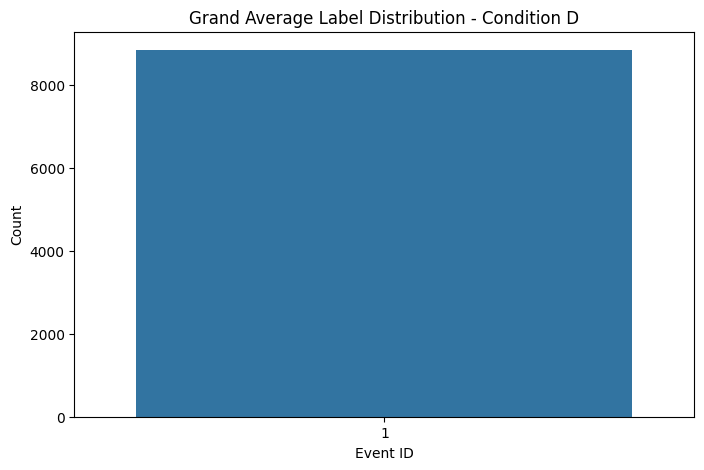

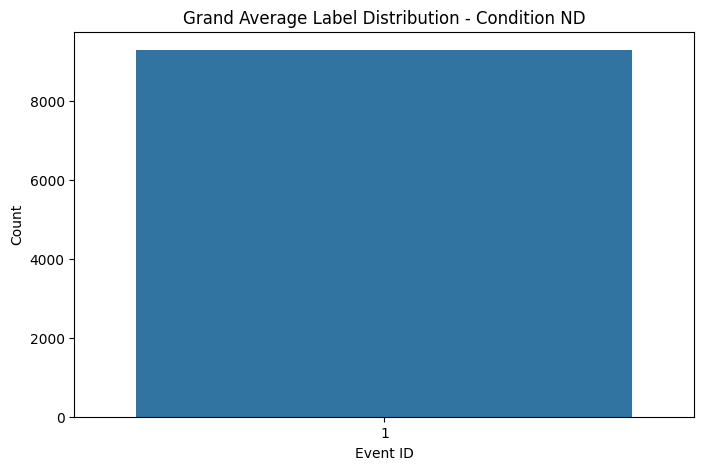

In [10]:
# Plot grand average for both conditions
plot_grand_average_label_distribution(event_count_condition1, 'Condition D')
plot_grand_average_label_distribution(event_count_condition2, 'Condition ND')

In [12]:
event_count_condition1, event_count_condition2

({np.int32(1): np.int64(8850)}, {np.int32(1): np.int64(9283)})

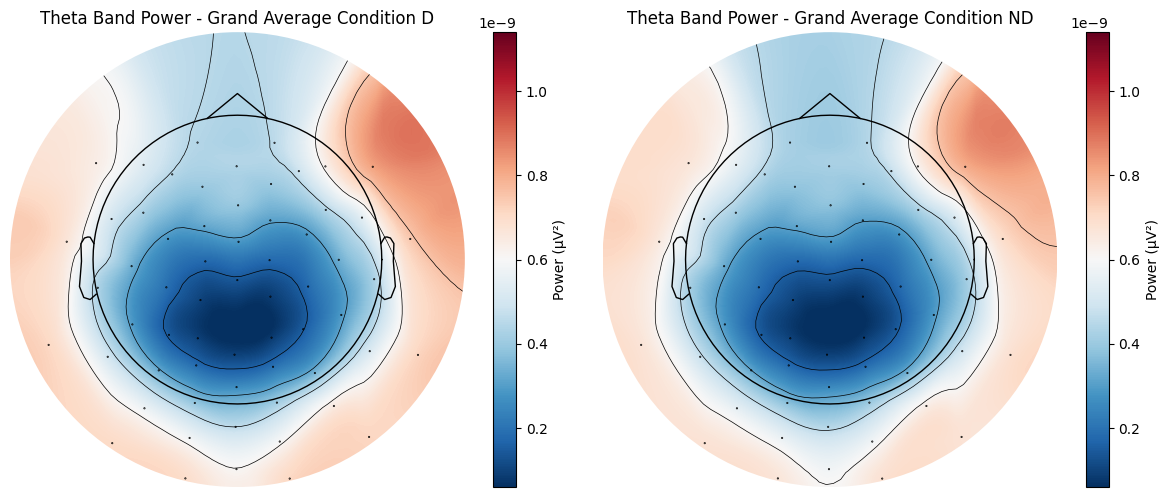

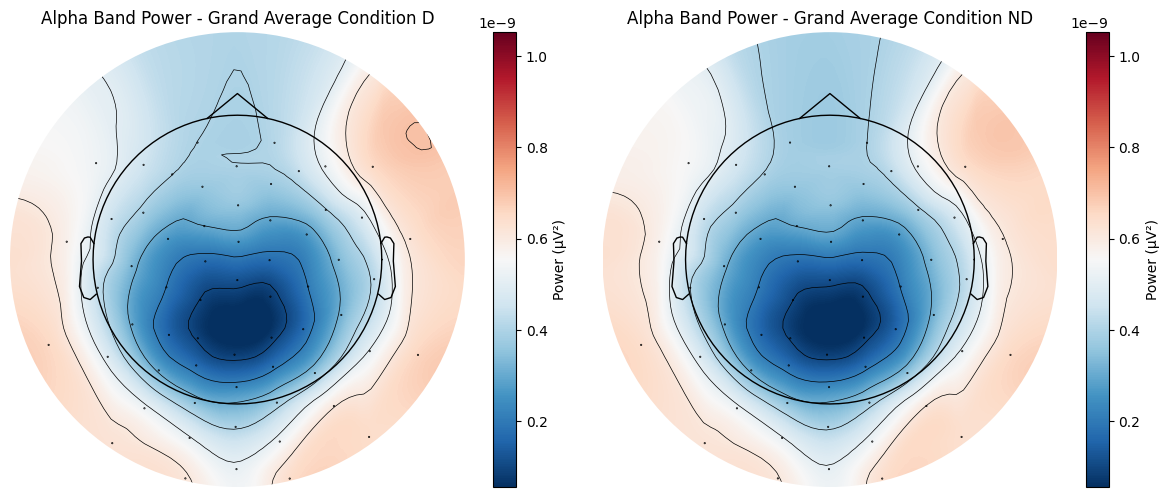

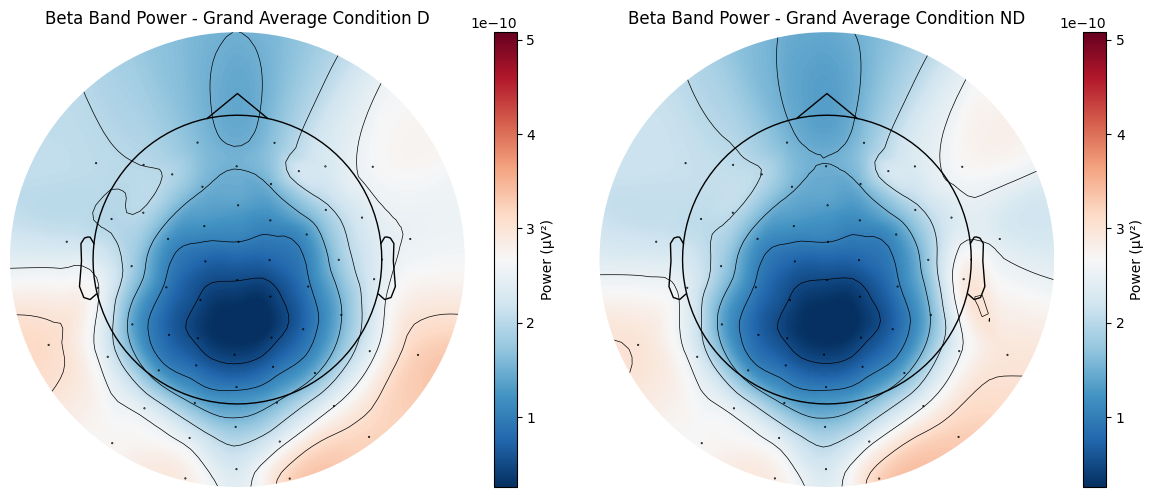

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_vmin_vmax_per_band(band_power_dict1, band_power_dict2, lower_percentile=2, upper_percentile=98):
    """Calculate vmin and vmax per band using percentiles to remove outliers."""
    vmin_vmax_per_band = {}

    # Loop over each band and calculate the percentiles for vmin and vmax
    for band in band_power_dict1.keys():
        all_data = []
        # Collect data from both conditions for the current band
        all_data.extend(band_power_dict1[band])
        all_data.extend(band_power_dict2[band])
        
        # Flatten the list and calculate the percentiles for the current band
        all_data_flat = np.concatenate(all_data)
        vmin = np.percentile(all_data_flat, lower_percentile)  # Lower percentile for vmin
        vmax = np.percentile(all_data_flat, upper_percentile)  # Upper percentile for vmax
        
        # Store the vmin and vmax for the current band
        vmin_vmax_per_band[band] = (vmin, vmax)
    
    return vmin_vmax_per_band

def plot_juxtaposed_grand_average_band_power(band_power_dict1, band_power_dict2, condition_name1, condition_name2, epochs_info):
    """Plot juxtaposed grand average band power topographies for two conditions side by side with per-band vmin and vmax."""
    
    # Calculate vmin and vmax per band
    vmin_vmax_per_band = calculate_vmin_vmax_per_band(band_power_dict1, band_power_dict2)
    
    for band in band_power_dict1.keys():  # Iterate over all frequency bands
        # Compute grand average for both conditions for the current band
        grand_average_band_power1 = np.mean(band_power_dict1[band], axis=0)  # Condition 1
        grand_average_band_power2 = np.mean(band_power_dict2[band], axis=0)  # Condition 2
        
        # Get vmin and vmax for the current band
        vmin, vmax = vmin_vmax_per_band[band]
        
        # Create a subplot with 2 columns (side-by-side plots)
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot Condition 1 topography
        im1, _ = mne.viz.plot_topomap(
            grand_average_band_power1, epochs_info, axes=axes[0], show=False, cmap='RdBu_r', vlim=(vmin,vmax)
        )
        axes[0].set_title(f'{band.capitalize()} Band Power - Grand Average {condition_name1}')
        cbar1 = plt.colorbar(im1, ax=axes[0])
        cbar1.set_label('Power (µV²)')
        
        # Plot Condition 2 topography
        im2, _ = mne.viz.plot_topomap(
            grand_average_band_power2, epochs_info, axes=axes[1], show=False, cmap='RdBu_r', vlim=(vmin,vmax)
        )
        axes[1].set_title(f'{band.capitalize()} Band Power - Grand Average {condition_name2}')
        cbar2 = plt.colorbar(im2, ax=axes[1])
        cbar2.set_label('Power (µV²)')
        
        # Display the plot
        plt.tight_layout()
        plt.show()

# Example call:
plot_juxtaposed_grand_average_band_power(
    band_power_condition1,  # Band power dictionary for Condition D
    band_power_condition2,  # Band power dictionary for Condition ND
    'Condition D',          # Name for Condition 1
    'Condition ND',         # Name for Condition 2
    epochs_condition1.info  # EEG channel information
)


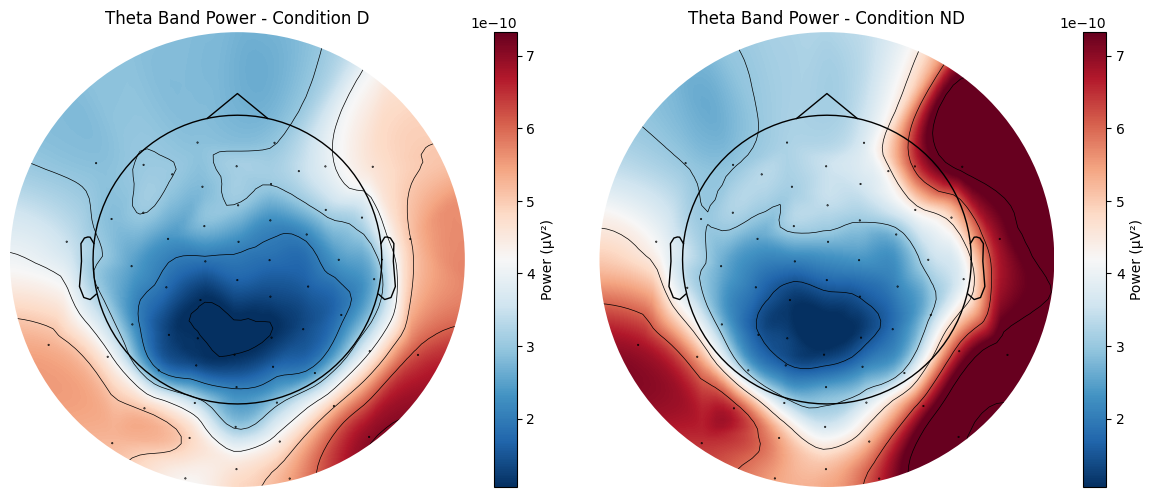

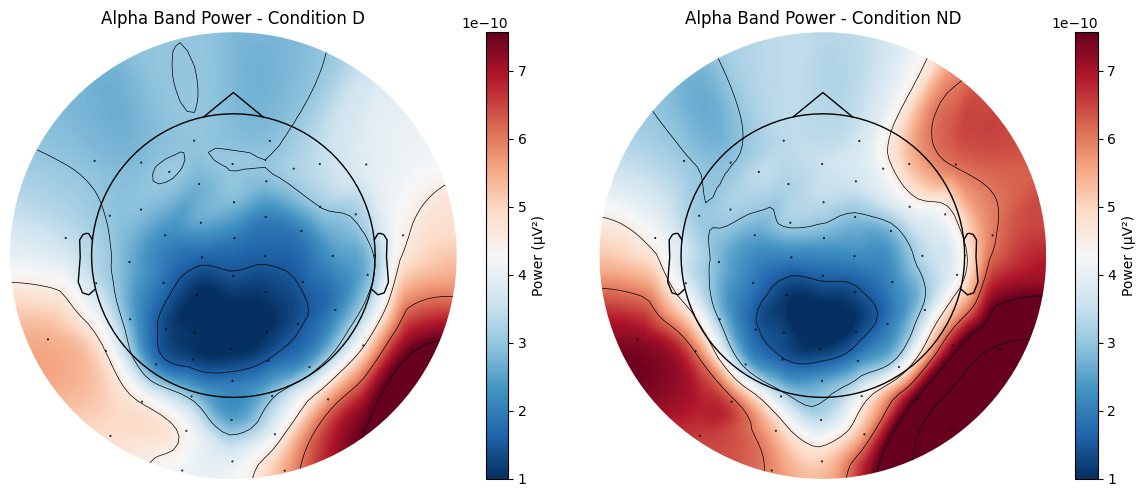

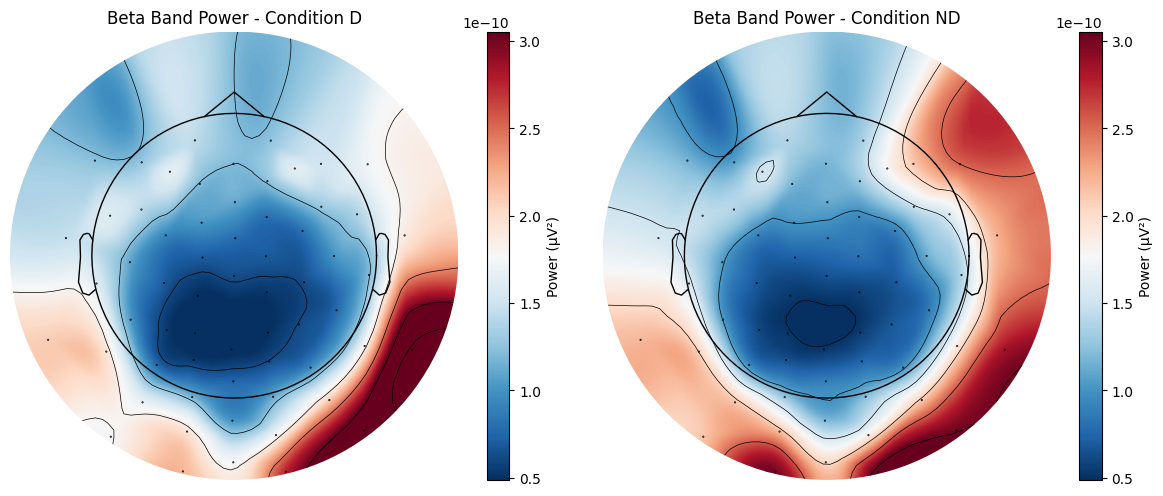

In [59]:
participant_id = 11
particpant_bandpower_cond1 = {band: participants_data[participant_id] for band, participants_data in band_power_condition1.items()} # Band power dictionary for Condition D
particpant_bandpower_cond2 = {band: participants_data[participant_id] for band, participants_data in band_power_condition2.items()} # Band power dictionary for Condition D


def calculate_vmin_vmax_per_band_per_partcipant(participant_band_power_dict1, participant_band_power_dict2, lower_percentile=2, upper_percentile=98):
    """Calculate vmin and vmax per band using percentiles to remove outliers for a specific participant."""
    vmin_vmax_per_band = {}
    # Loop over each band and calculate the percentiles for vmin and vmax
    for band in participant_band_power_dict1.keys():
        all_data = []
        # Collect data from both conditions for the current band
        all_data.extend([np.atleast_1d(data) for data in participant_band_power_dict1[band]])
        all_data.extend([np.atleast_1d(data) for data in participant_band_power_dict2[band]])
        
        # Flatten the list and calculate the percentiles for the current band
        all_data_flat = np.concatenate(all_data)
        vmin = np.percentile(all_data_flat, lower_percentile)  # Lower percentile for vmin
        vmax = np.percentile(all_data_flat, upper_percentile)  # Upper percentile for vmax
        
        # Store the vmin and vmax for the current band
        vmin_vmax_per_band[band] = (vmin, vmax)
    
    return vmin_vmax_per_band

def plot_participant_band_power(participant_band_power_dict1, participant_band_power_dict2, condition_name1, condition_name2, epochs_info):
    """Plot band power topographies for a specific participant side by side with per-band vmin and vmax."""
    
    # Calculate vmin and vmax per band for the specific participant
    vmin_vmax_per_band = calculate_vmin_vmax_per_band_per_partcipant(participant_band_power_dict1, participant_band_power_dict2)
    
    for band in participant_band_power_dict1.keys():  # Iterate over all frequency bands
        # Get the band power for the specific participant for both conditions
        band_power1 = participant_band_power_dict1[band]  # Condition 1
        band_power2 = participant_band_power_dict2[band]  # Condition 2
        
        # Get vmin and vmax for the current band
        vmin, vmax = vmin_vmax_per_band[band]
        
        # Create a subplot with 2 columns (side-by-side plots)
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot Condition 1 topography
        im1, _ = mne.viz.plot_topomap(
            band_power1, epochs_info, axes=axes[0], show=False, cmap='RdBu_r',  vlim=(vmin,vmax)
        )
        axes[0].set_title(f'{band.capitalize()} Band Power - {condition_name1}')
        cbar1 = plt.colorbar(im1, ax=axes[0])
        cbar1.set_label('Power (µV²)')
        
        # Plot Condition 2 topography
        im2, _ = mne.viz.plot_topomap(
            band_power2, epochs_info, axes=axes[1], show=False, cmap='RdBu_r',  vlim=(vmin,vmax)
        )
        axes[1].set_title(f'{band.capitalize()} Band Power - {condition_name2}')
        cbar2 = plt.colorbar(im2, ax=axes[1])
        cbar2.set_label('Power (µV²)')
        
        # Display the plot
        plt.tight_layout()
        plt.show()

plot_participant_band_power(
    particpant_bandpower_cond1,  # Band power dictionary for Condition D for a specific participant
    particpant_bandpower_cond2,  # Band power dictionary for Condition ND for a specific participant
    'Condition D',                      # Name for Condition 1
    'Condition ND',                     # Name for Condition 2
      epochs_condition1.info                         # EEG channel information
)


In [44]:
np.array(particpant_bandpower_cond1['beta']).shape

(62,)

In [18]:
# Convert results to DataFrame and save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('classification_results.csv', index=False)


In [9]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import mne

# Define classifiers to test
classifiers = {
    'LogisticRegression': LogisticRegression(),
    'SVM': SVC(),
    'LDA': LinearDiscriminantAnalysis(),
    'KNN': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier()
}


freq_bands = {'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30)}


event_count_condition1 = {}
event_count_condition2 = {}
band_power_condition1 = {}
band_power_condition2 = {}

# Example filenames
condition1_file_template = "path_to_data/participant_{id}_condition1-epo.fif"
condition2_file_template = "path_to_data/participant_{id}_condition2-epo.fif"

valid_pids = [el for el in list(range(1,32)) if el not in [14, 5, 13, 16, 17, 20, 31]]

# Variables to store features, labels, and groups
all_X = []
all_y = []
all_groups = []

# Iterate through all participants
for participant_id in valid_pids:

    # Load epochs for both conditions
    epochs_condition1 = load_participant_epochs(participant_id, 'D')
    epochs_condition2 = load_participant_epochs(participant_id, 'ND')
    
    # Combine both epochs for classification
    combined_epochs = mne.concatenate_epochs([epochs_condition1, epochs_condition2])

    # Collect label distribution and band power topography
    collect_label_distribution(epochs_condition1, event_count_condition1)
    collect_label_distribution(epochs_condition2, event_count_condition2)
    collect_band_power_topography(epochs_condition1, freq_bands, band_power_condition1)
    collect_band_power_topography(epochs_condition2, freq_bands, band_power_condition2)

    # Extract PSD features for both conditions
    X_condition1 = get_psd_features(epochs_condition1, freq_bands)
    X_condition2 = get_psd_features(epochs_condition2, freq_bands)

    # Combine PSD features
    X_combined = np.concatenate([X_condition1, X_condition2], axis=0)

    n_epochs_condition1 = len(epochs_condition1)
    n_epochs_condition2 = len(epochs_condition2)

    # Assign labels: Condition 1 = 1, Condition 2 = 0
    y_condition1 = np.ones(n_epochs_condition1, dtype=int)
    y_condition2 = np.zeros(n_epochs_condition2, dtype=int)
    
    # Combine the labels
    y_combined = np.concatenate([y_condition1, y_condition2], axis=0)

    # Track participant IDs for grouping
    groups = np.full(len(y_combined), participant_id)

    # Append to the overall data
    all_X.append(X_combined)
    all_y.append(y_combined)
    all_groups.append(groups)

# Concatenate all participant data
all_X = np.concatenate(all_X, axis=0)
all_y = np.concatenate(all_y, axis=0)
all_groups = np.concatenate(all_groups, axis=0)

# Standardize the features
scaler = StandardScaler()
all_X_scaled = scaler.fit_transform(all_X)

# Initialize Leave-One-Group-Out cross-validator
logo = LeaveOneGroupOut()

# Store the classification results
results = []

# Perform LOGO cross-validation
for train_index, test_index in logo.split(all_X_scaled, all_y, all_groups):
    X_train, X_test = all_X_scaled[train_index], all_X_scaled[test_index]
    y_train, y_test = all_y[train_index], all_y[test_index]
    
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        results.append({
            'classifier': name,
            'participant_left_out': all_groups[test_index][0],
            'score': score
        })

# Results now contain the classification performance per classifier and left-out participant.


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
113 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


420 matching events found
No baseline correction applied
Not setting metadata
829 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices 

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


443 matching events found
No baseline correction applied
Not setting metadata
843 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


670 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events found
No baseline correctio

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


758 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events found
No baseline correction

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
755 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
108 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
776 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
115 matching events found


C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
875 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
126 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
111 matching events found

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


441 matching events found
No baseline correction applied
Not setting metadata
890 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matric

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
137 matching events found
No baseline correction applied
0 projection items activated
Reading c:\User

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


450 matching events found
No baseline correction applied
Not setting metadata
883 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matric

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection 

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
802 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events fo

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


437 matching events found
No baseline correction applied
Not setting metadata
889 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matri

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


445 matching events found
No baseline correction applied
Not setting metadata
888 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matri

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


0 projection items activated
Not setting metadata
465 matching events found
No baseline correction applied
Not setting metadata
905 matching events found
No baseline correction applied


C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\User

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
825 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events foun

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
749 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events fou

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
90 matching events found
No baseline correction applied
0 projection i

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


390 matching events found
No baseline correction applied
Not setting metadata
714 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matric

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


641 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
123 matching events found
No baseline correc

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


443 matching events found
No baseline correction applied
Not setting metadata
842 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matri

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


318 matching events found
No baseline correction applied
Not setting metadata
666 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matric

C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_25996\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


No baseline correction applied
Not setting metadata
835 matching events found
No baseline correction applied


c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

In [ ]:
import pandas as pd

# Assuming `results` is the list of dictionaries containing classifier results
# Example: [{'classifier': 'SVM', 'participant_left_out': 1, 'score': 0.9}, ...]

# Convert results into a DataFrame
df_results = pd.DataFrame(results)

df_results.to_csv('classification_results1_logo_detailed.csv', index=False)

# Group by classifier and calculate the mean and standard deviation for the accuracy
summary = df_results.groupby('classifier')['score'].agg(['mean', 'std']).reset_index()

# Save the results to CSV
summary.to_csv('classification_results1_logo_summary.csv', index=False)



In [8]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import mne
import pandas as pd

# Define classifiers to test
classifiers = {
    'LogisticRegression': LogisticRegression(),
    'SVM': SVC(),
    'LDA': LinearDiscriminantAnalysis(),
    'KNN': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier()
}

# Define frequency bands
freq_bands = {'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30)}

# List of valid participants
valid_pids = [el for el in range(1, 32) if el not in [5, 13, 14, 16, 17, 20, 31]]

# Store the classification results
results = []

# Iterate through all participants and bands
for participant_id in valid_pids:
    # Load epochs for both conditions (you will need to define 'load_participant_epochs' function)
    epochs_condition1 = load_participant_epochs(participant_id, 'D')
    epochs_condition2 = load_participant_epochs(participant_id, 'ND')
    
    # Combine both epochs for classification
    combined_epochs = mne.concatenate_epochs([epochs_condition1, epochs_condition2])
    
    # Iterate over each frequency band
    for band_name, band_freqs in freq_bands.items():
        # Extract PSD features for both conditions (you will need to define 'get_psd_features' function)
        X_condition1 = get_psd_features(epochs_condition1, {band_name: band_freqs})
        X_condition2 = get_psd_features(epochs_condition2, {band_name: band_freqs})
        
        # Combine PSD features
        X_combined = np.concatenate([X_condition1, X_condition2], axis=0)
        
        # Assign labels: Condition 1 = 1, Condition 2 = 0
        y_condition1 = np.ones(len(epochs_condition1), dtype=int)
        y_condition2 = np.zeros(len(epochs_condition2), dtype=int)
        y_combined = np.concatenate([y_condition1, y_condition2], axis=0)
        
        # Standardize the features
        scaler = StandardScaler()
        X_combined_scaled = scaler.fit_transform(X_combined)
        
        # Perform 5-fold cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        for name, clf in classifiers.items():
            fold_accuracies = []
            
            for train_index, test_index in kf.split(X_combined_scaled):
                X_train, X_test = X_combined_scaled[train_index], X_combined_scaled[test_index]
                y_train, y_test = y_combined[train_index], y_combined[test_index]
                
                # Fit the classifier
                clf.fit(X_train, y_train)
                
                # Calculate accuracy
                accuracy = clf.score(X_test, y_test)
                fold_accuracies.append(accuracy)
            
            # Compute mean and std accuracy
            mean_accuracy = np.mean(fold_accuracies)
            std_accuracy = np.std(fold_accuracies)
            
            # Store the results
            results.append({
                'participant': participant_id,
                'classifier': name,
                'band': band_name,
                'mean_accuracy': mean_accuracy,
                'std_accuracy': std_accuracy
            })

# Create a DataFrame from the results and save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('Powerband_classification_results_perband.csv', index=False)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
113 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


420 matching events found
No baseline correction applied
Not setting metadata
829 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices 

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


No baseline correction applied
Not setting metadata
843 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting met

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events found
No baseline correction applied
0 projection ite

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


758 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events found
No baseline correction

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


755 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
108 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correcti

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


776 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
115 matching events found
No baseline correctio

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


875 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
126 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
111 matching events found
No baseline correcti

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


139 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
441 matching events found
No baseline correction applied
Not setting metadata
890 matching events found
No baseline correction applied


C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
137 matching events found
No baseline correction applied
0 projection items activated
Reading c:\User

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


883 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correct

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Reading c:\User

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
802 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events fo

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


No baseline correction applied
Not setting metadata
889 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting 

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
888 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events fo

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
905 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events fou

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


825 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events found
No baseline correct

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


749 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correc

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Reading c:\User

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


842 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events found
No baseline correc

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
109 matching events found
No baseline correction applied
0 projection 

C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_18344\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
835 matching events found
No baseline correction applied


In [ ]:
#without auditory cortex
#right: 2RD, 3RD, 3RC
#left: 2LD, 3LD, 3LC
